## Some plots of the output

Spectra, percentiles (real and predicted) and some components of the latents

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30


In [2]:
wave=np.load('./saved_input/wave_non_par_alpha.npy')
x_test=np.load('../../seds_large/alpha_fe/seds_non_par_alpha_reshaped.npy')
ind=np.load('./saved_models/ind_sh_non_par_alpha.npy')
x_test=x_test[ind,:][-45000:]
y_test=np.load('./saved_models/y_test.npy',allow_pickle=True)
ys_=np.load('./saved_models/y_test_pred.npy',allow_pickle=True)
latents=np.load('./saved_models/latents.npy',allow_pickle=True)
print(np.shape(y_test),np.shape(ys_),np.shape(latents))

(352,) (352,) (352,)


Index 58
Index 54
Index 3
Index 19
Index 39
Index 45
Index 47
Index 106
Index 54
Index 69


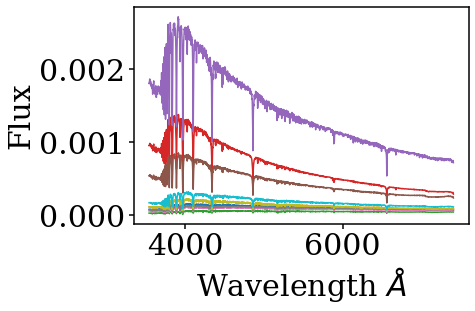

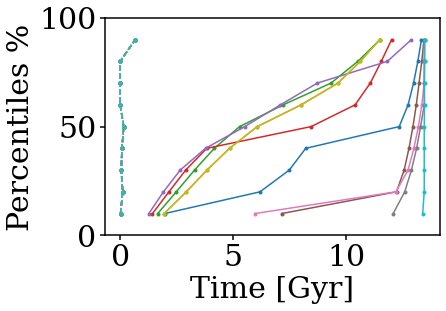

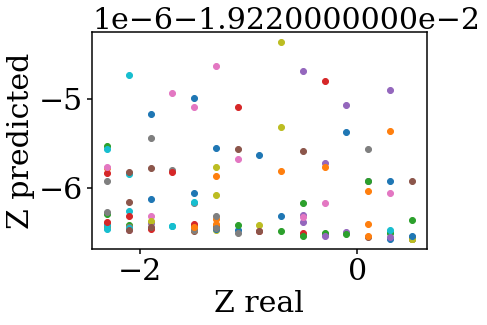

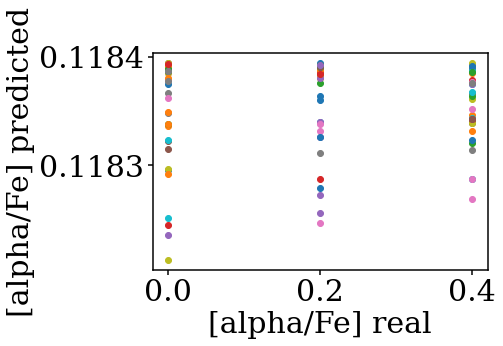

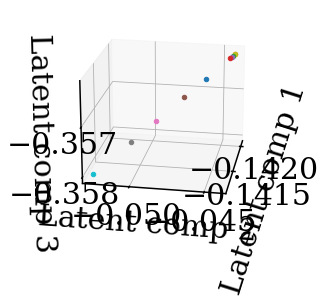

In [4]:
ind=np.random.choice(np.arange(128),size=10)
color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','gold']

#999 works pretty well
#spectrum
for i,index in enumerate(ind):
    print('Index '+str(index))
    plt.plot(wave,x_test[index,:],color=color[i])
plt.xlabel('Wavelength $\\AA$')
plt.ylabel('Flux')
plt.show()

#percentiles vs time
for i,index in enumerate(ind):
    plt.plot(y_test[0][index,:9],np.arange(10,100,10),'.-',label='real',color=color[i])
    plt.plot(ys_[0][index,:9],np.arange(10,100,10),'.--',label='predicted',color=color[i])
plt.ylabel('Percentiles %')
plt.xlabel('Time [Gyr]')
#plt.xlim(0,14)
#plt.xlim(2,4)
plt.ylim(0,100)
#plt.legend()
plt.show()

#metallicity
for i,index in enumerate(range(128)):
 plt.plot(y_test[0][index,-2],ys_[0][index,-2],'o',label='real',color='C'+str(i))
plt.xlabel('Z real')
plt.ylabel('Z predicted')
plt.show()


#alpha fe
for i,index in enumerate(range(128)):
 plt.plot(y_test[0][index,-1],ys_[0][index,-1],'o',label='real',color='C'+str(i))
plt.xlabel('[alpha/Fe] real')
plt.ylabel('[alpha/Fe] predicted')
plt.show()

#latent space (1,2,3)
plt.figure()
ax = plt.axes(projection='3d')
for i,index in enumerate(ind):
    ax.scatter3D(latents[0][index,4],latents[0][index,5],latents[0][index,6],color=color[i])
ax.set_xlabel('Latent comp 1')
ax.set_ylabel('Latent comp 2')
ax.set_zlabel('Latent comp 3')
ax.view_init(20, 10)
plt.show()

#predicts bad the 'young population'


## Embedding the latents

We need to visualize better percentiles. We use the UMAP tool.

In [5]:
from tqdm import tqdm

batch_size=128
test_set=45000
n_latent=16

percent_pred_arr=np.zeros((test_set,11))
latents_arr=np.zeros((test_set,n_latent))
percent_arr=np.zeros((test_set,11))


for j in tqdm(range(len(ys_))):
    for i,x in enumerate(ys_[j]):
        percent_pred_arr[batch_size*j+i,:]=x
        
for j in tqdm(range(len(latents))):
    for i,x in enumerate(latents[j]):
        latents_arr[batch_size*j+i,:]=x
        
for j in tqdm(range(len(y_test))):
    for i,x in enumerate(y_test[j]):
        percent_arr[batch_size*j+i,:]=x

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:00<00:00, 7796.15it/s]


In [7]:
y_test=np.copy(percent_arr)



#!pip install umap-learn
import umap.umap_ as umap
reducer = umap.UMAP()
embed = reducer.fit_transform(latents_arr[:,:]) #train each time, if not, just transform


/opt/python/python3.8/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


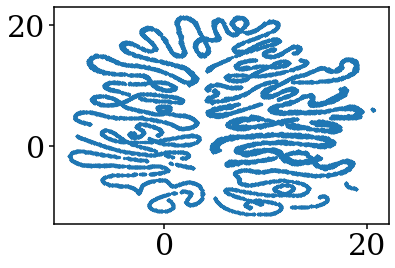

In [9]:


# no coloring
plt.scatter(embed[:,0], embed[:,1], s=5, c='tab:blue', rasterized=True)
plt.show()



In [ ]:
#which is the shape of the actual seds (no latents) - maybe too much dimensions to represent, but let's see

embed_sed = reducer.fit_transform(x_test)


In [ ]:
print(np.shape(embed_sed))
plt.scatter(embed_sed[:,0], embed_sed[:,1], s=5, c='tab:blue', rasterized=True)
plt.show()

left=np.where(embed_sed[:,0]<0)[0]
right=np.where(embed_sed[:,0]>10)[0]

for l in left:
    if l==left[0]:
        plt.plot(wave,x_test[l,:],color='r',label='left',alpha=0.5)
    else:
        plt.plot(wave,x_test[l,:],color='r',alpha=0.5)
      
for r in right:
    if r==right[0]:
        plt.plot(wave,x_test[r,:],color='b',label='right',alpha=0.5)
    else:
        plt.plot(wave,x_test[r,:],color='b',alpha=0.5)
        

plt.xlabel('Wavelength $\\AA$')
plt.ylabel('Flux')
plt.legend()
plt.show()



## Halpha

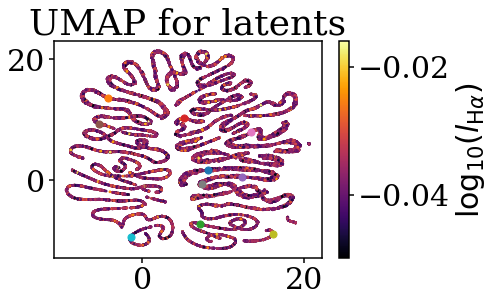

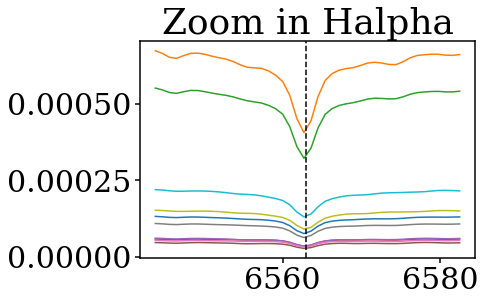

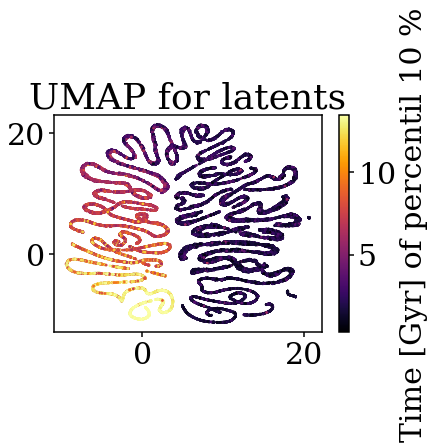

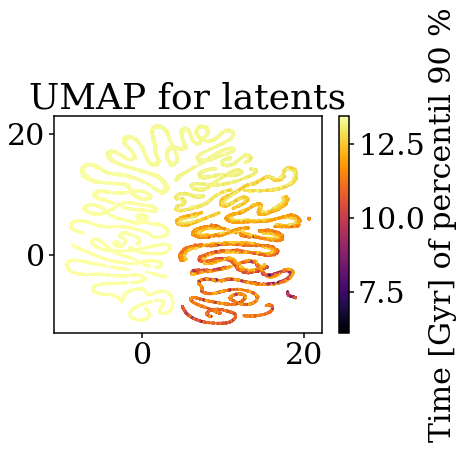

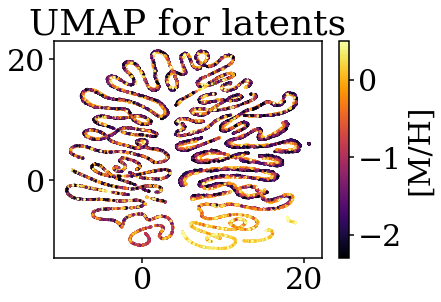

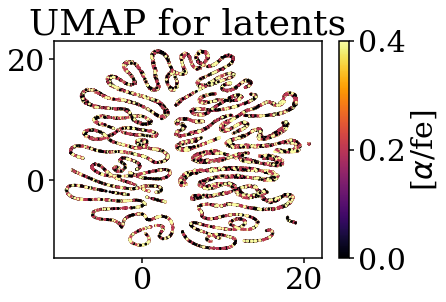

In [12]:
#lets try to see the dependance of the UMAP for latents with halpha

# Halpha

def l(l_center=6563,delta=20):
    sel = (wave > l_center-delta) & (wave < l_center+delta)
    diff = x_test[:,sel]
    #print(np.shape(diff),np.shape(np.sum(diff,axis=1)),np.shape(np.median(x_test,axis=1)))
    #return np.sum(diff,axis=1)/np.median(x_test,axis=1)
    #return np.sum(diff,axis=1)/np.max(x_test,axis=1)
    near=(wave > l_center-200) & (wave < l_center+200)
    return np.mean(diff,axis=1) / np.median(x_test[:,near],axis=1)

color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','gold']


#the maximum is to avoid divergences
plt.scatter(embed[:,0], embed[:,1], s=3, c=np.log10(np.maximum(1e-2,l(l_center=6563))), rasterized=True, cmap='inferno')
plt.colorbar(label=r'$\log_{10}(l_{\mathrm{H}\alpha})$')
plt.title('UMAP for latents')
for i,ind in enumerate(np.arange(0,45000,4500)):
    plt.scatter(embed[ind,0], embed[ind,1], s=50, c=color[i], rasterized=True, cmap='inferno')
plt.show()


sel = (wave > 6543) & (wave < 6583)
diff = x_test[:,sel]

for i,ind in enumerate(np.arange(0,45000,4500)):
    plt.plot(wave[sel],diff[ind,:],color=color[i])
plt.axvline(6563,0,1,ls='--',c='k')
plt.title('Zoom in Halpha')
plt.show()

#lets try to see the dependance with time percentile 10% (a bit random)
plt.scatter(embed[:,0], embed[:,1], s=3, c=y_test[:,0], rasterized=True, cmap='inferno')
plt.colorbar(label='Time [Gyr] of percentil 10 %')
plt.title('UMAP for latents')
plt.show()

#lets try to see the dependance with time percentile 90% (as expected from the seds)
#galaxies from the right formed all their stars soon

plt.scatter(embed[:,0], embed[:,1], s=3, c=y_test[:,-3], rasterized=True, cmap='inferno')
plt.colorbar(label='Time [Gyr] of percentil 90 %')
plt.title('UMAP for latents')
plt.show()


#lets try to see the dependance with metallicity (as expected from the seds)

plt.scatter(embed[:,0], embed[:,1], s=3, c=y_test[:,-2], rasterized=True, cmap='inferno')
plt.colorbar(label='[M/H]')
plt.title('UMAP for latents')
plt.show()


#lets try to see the dependance with metallicity (as expected from the seds)

plt.scatter(embed[:,0], embed[:,1], s=3, c=y_test[:,-1], rasterized=True, cmap='inferno')
plt.colorbar(label='[$\\alpha$/fe]')
plt.title('UMAP for latents')
plt.show()

## Hbeta

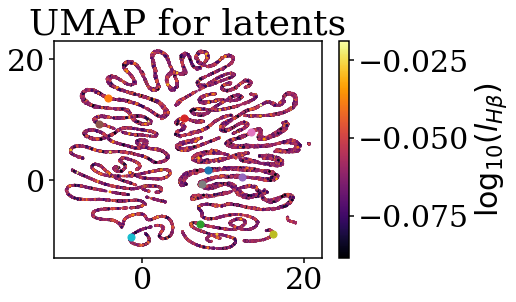

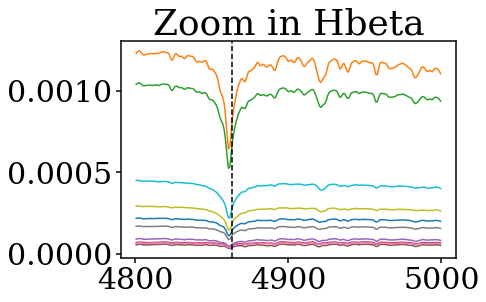

In [13]:
#lets try to see the dependance of the UMAP for latents with Hbeta

color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','gold']

#the maximum is to avoid divergences
plt.scatter(embed[:,0], embed[:,1], s=3, c=np.log10(np.maximum(1e-2,l(l_center=4863))), rasterized=True, cmap='inferno')
plt.colorbar(label=r'$\log_{10}(l_{H \beta})$')
plt.title('UMAP for latents')
for i,ind in enumerate(np.arange(0,45000,4500)):
    plt.scatter(embed[ind,0], embed[ind,1], s=50, c=color[i], rasterized=True, cmap='inferno')
plt.show()


sel = (wave > 4800 ) & (wave < 5000)
diff = x_test[:,sel]

for i,ind in enumerate(np.arange(0,45000,4500)):
    plt.plot(wave[sel],diff[ind,:],color=color[i])
plt.axvline(4863,0,1,ls='--',c='k')
plt.title('Zoom in Hbeta')
plt.show()

## OII

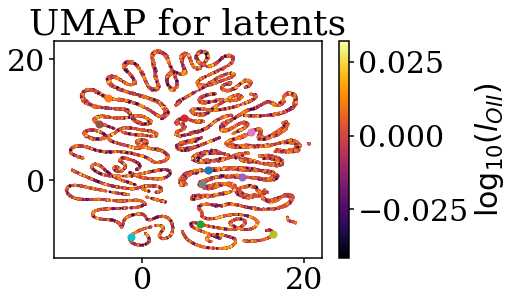

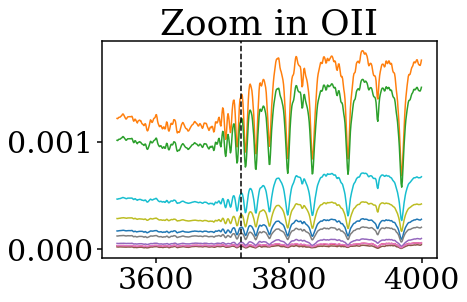

In [14]:
#lets try to see the dependance of the UMAP for latents with OII

color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','gold']

#the maximum is to avoid divergences
plt.scatter(embed[:,0], embed[:,1], s=3, c=np.log10(np.maximum(1e-2,l(l_center=3727))), rasterized=True, cmap='inferno')
plt.colorbar(label=r'$\log_{10}(l_{OII})$')
plt.title('UMAP for latents')
for i,ind in enumerate(np.arange(0,45000,4500)):
    plt.scatter(embed[ind,0], embed[ind,1], s=50, c=color[i], rasterized=True, cmap='inferno')
plt.show()


sel = (wave > 3000 ) & (wave < 4000)
diff = x_test[:,sel]

for i,ind in enumerate(np.arange(0,45000,4500)):
    plt.plot(wave[sel],diff[ind,:],color=color[i])
plt.axvline(3727,0,1,ls='--',c='k')
plt.title('Zoom in OII')
plt.show()

## Correlation between latents and spectrum regions

           1         2         3         4         5         6         7  \
1   1.000000  0.999609  0.999659 -0.999673 -0.999846  0.999700  0.999583   
2   0.999609  1.000000  0.999997 -0.999996 -0.999943  0.999990  0.999979   
3   0.999659  0.999997  1.000000 -1.000000 -0.999959  0.999998  0.999985   
4  -0.999673 -0.999996 -1.000000  1.000000  0.999963 -0.999999 -0.999984   
5  -0.999846 -0.999943 -0.999959  0.999963  1.000000 -0.999968 -0.999913   
6   0.999700  0.999990  0.999998 -0.999999 -0.999968  1.000000  0.999986   
7   0.999583  0.999979  0.999985 -0.999984 -0.999913  0.999986  1.000000   
8   0.999697  0.999873  0.999906 -0.999909 -0.999883  0.999929  0.999941   
9   0.999716  0.999988  0.999990 -0.999991 -0.999979  0.999986  0.999950   
10  0.999638  0.999998  1.000000 -0.999999 -0.999951  0.999996  0.999988   
11  0.999636  0.999997  1.000000 -0.999999 -0.999950  0.999996  0.999989   
12 -0.999613 -0.999999 -0.999998  0.999997  0.999943 -0.999993 -0.999985   
13 -0.999615

<AxesSubplot:>

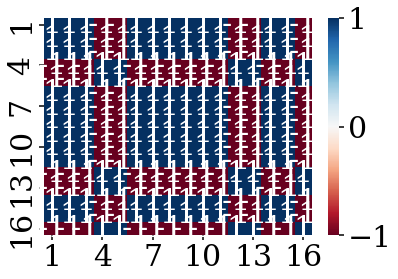

In [19]:
#first correlations inside the latents

import pandas as pd
import seaborn as sns



latent_data=pd.DataFrame(latents_arr, columns = [str(i) for i in range(1,17)])
corr = latent_data.corr()
print(corr)
sns.heatmap(corr, cmap='RdBu',vmin=-1, vmax=1,annot=True)

In [20]:
print(np.shape(latents))

(352,)


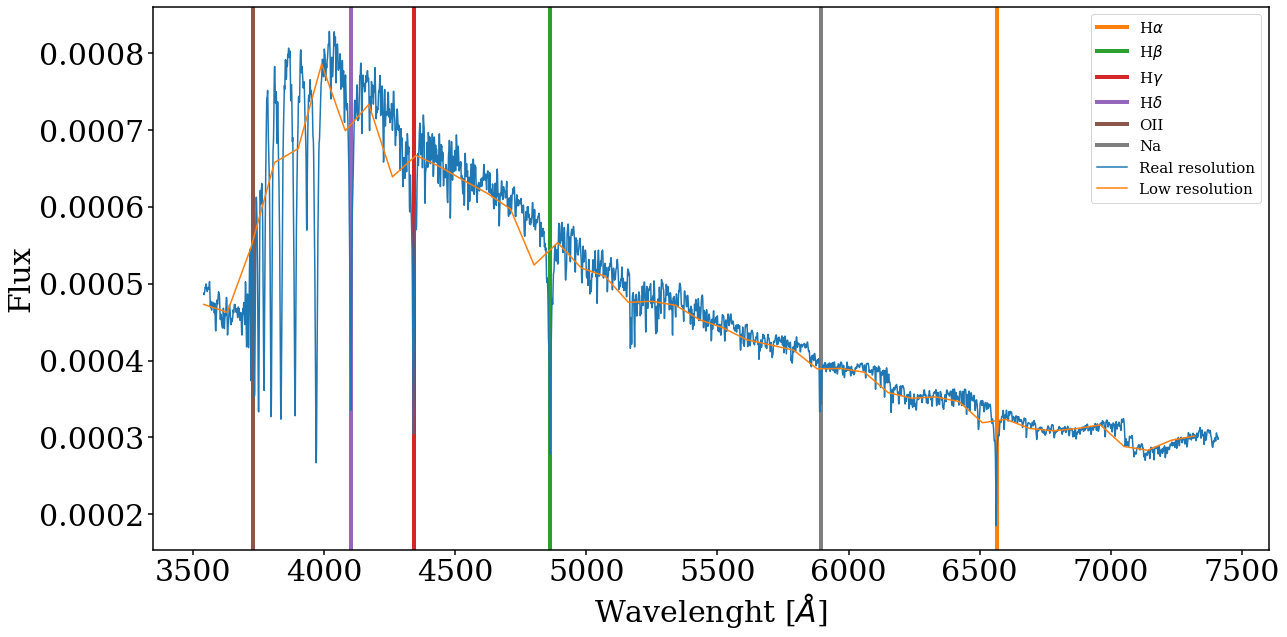

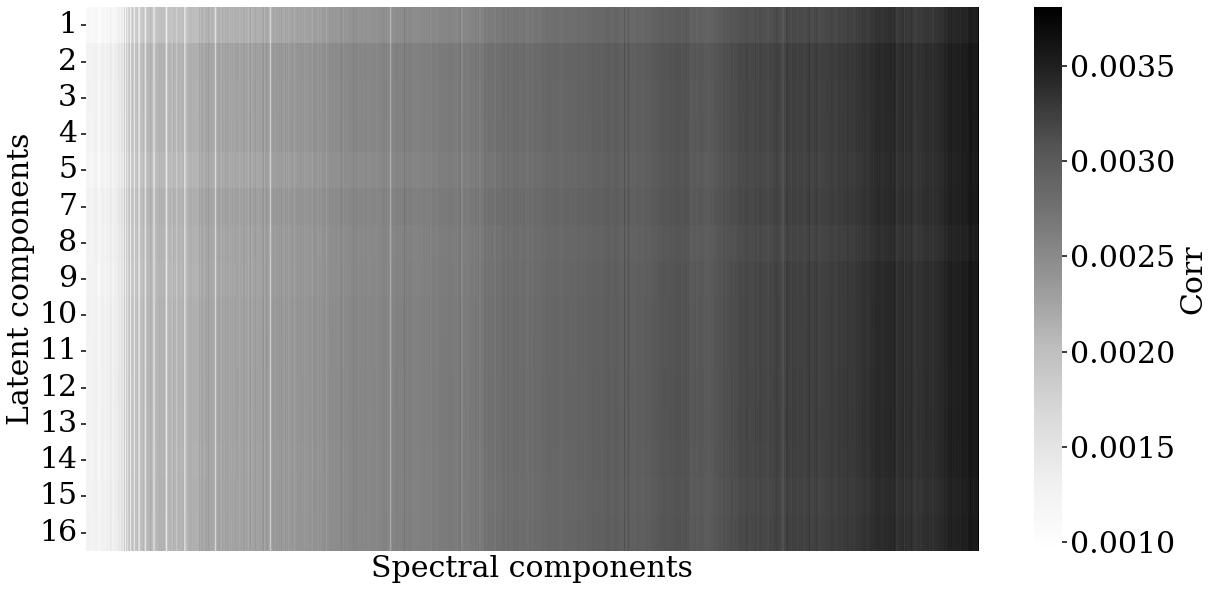

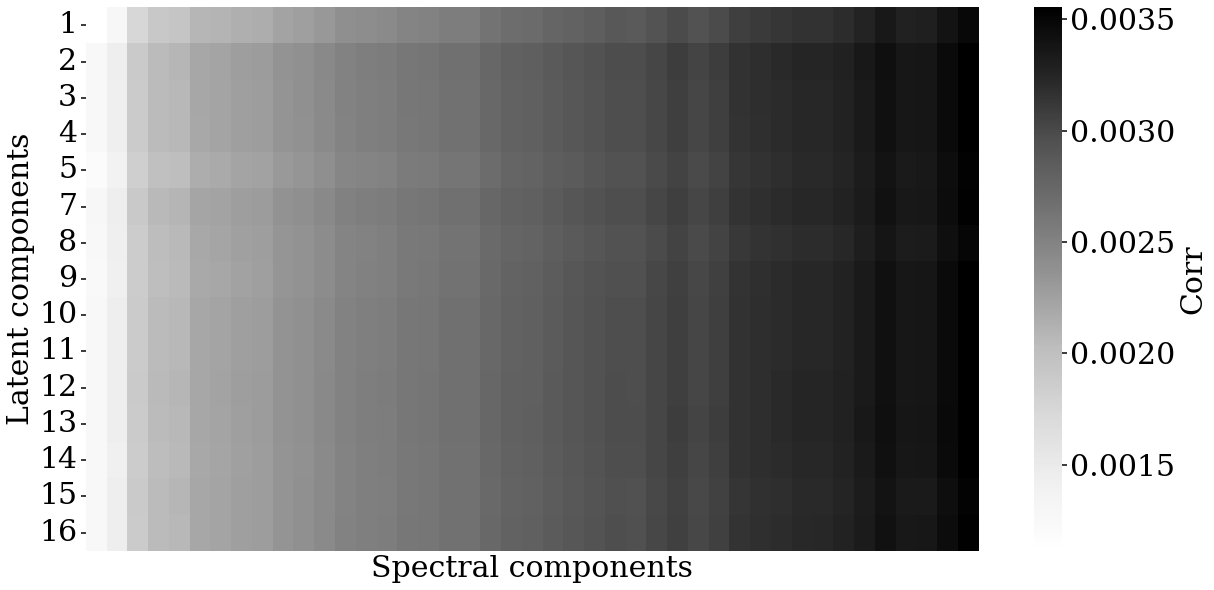

In [21]:
# correlation between latents and spectrum

import matplotlib

x_test_short=np.zeros((45000,43))


for i in range(43):
    x_test_short[:,i]=np.mean(x_test[:,i*100:(i+1)*100],axis=1)

color=['tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','gold']


plt.figure(figsize=(20,10))
#plt.xticks(np.arange(4300)[::200],labels=wave[::200],rotation=45)
plt.axvline( 6564.61,label='H$\\alpha$',lw=4,c=color[0])
plt.axvline(  4862.68,label='H$\\beta$',lw=4,c=color[1])
plt.axvline(4341.68,label='H$\\gamma$',lw=4,c=color[2])
plt.axvline(4102.89,label='H$\\delta$',lw=4,c=color[3])
plt.axvline(3727.092,label='OII',lw=4,c=color[4])
#plt.axvline(3729.875,lw=4,c=color[5]) #label='OII'
plt.axvline(5895.6,label='Na',lw=4,c=color[6])



plt.plot(wave,x_test[100,:],label='Real resolution') #real spectra
plt.plot(wave[::100],x_test_short[100,:],label='Low resolution') #low resolution spectra
plt.xlabel('Wavelenght [$\\AA$]')
plt.ylabel('Flux')
#plt.grid()

plt.legend(loc='upper right',fontsize=15)
#plt.savefig('spectra_example.png')
plt.show()



corr_map=np.corrcoef(latents_arr,x_test[:,:],rowvar=False)
corr_map_imp=corr_map[:16,16:]

#remove component 7 (anormal values)
corr_map_imp = np.delete(corr_map_imp, 5, axis=0)


#doesnt matter the sign of the correlation
plt.figure(figsize=(20,10))
sns.heatmap(np.abs(corr_map_imp), cmap='Greys',vmin=np.min(np.abs(corr_map_imp)), vmax=np.max(np.abs(corr_map_imp)),xticklabels=[],\
            yticklabels=[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16],cbar_kws={'label': 'Corr'})
plt.xlabel('Spectral components')
plt.ylabel('Latent components')
#plt.savefig('corr_spectra_allpos_smooth.png')
plt.show()





corr_map=np.corrcoef(latents_arr,x_test_short,rowvar=False)
corr_map_imp=corr_map[:16,16:]
#remove component 6 (anormal values)
corr_map_imp = np.delete(corr_map_imp, 5, axis=0)


#doesnt matter the sign of the correlation
plt.figure(figsize=(20,10))
sns.heatmap(np.abs(corr_map_imp), cmap='Greys',vmin=np.min(np.abs(corr_map_imp)), vmax=np.max(np.abs(corr_map_imp)),xticklabels=[],\
            yticklabels=[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16],cbar_kws={'label': 'Corr'})
plt.xlabel('Spectral components')
plt.ylabel('Latent components')
#plt.savefig('corr_spectra_allpos.png')
plt.show()







In [ ]:
"""
#Corner plot takes too long
import corner
fig = corner.corner(np.concatenate([latents, x_test_short], axis=1), 
                 labels=np.concatenate([col_lat,col_spec]),
                 label_kwargs={'fontsize': 25},
                 color='C0')
"""

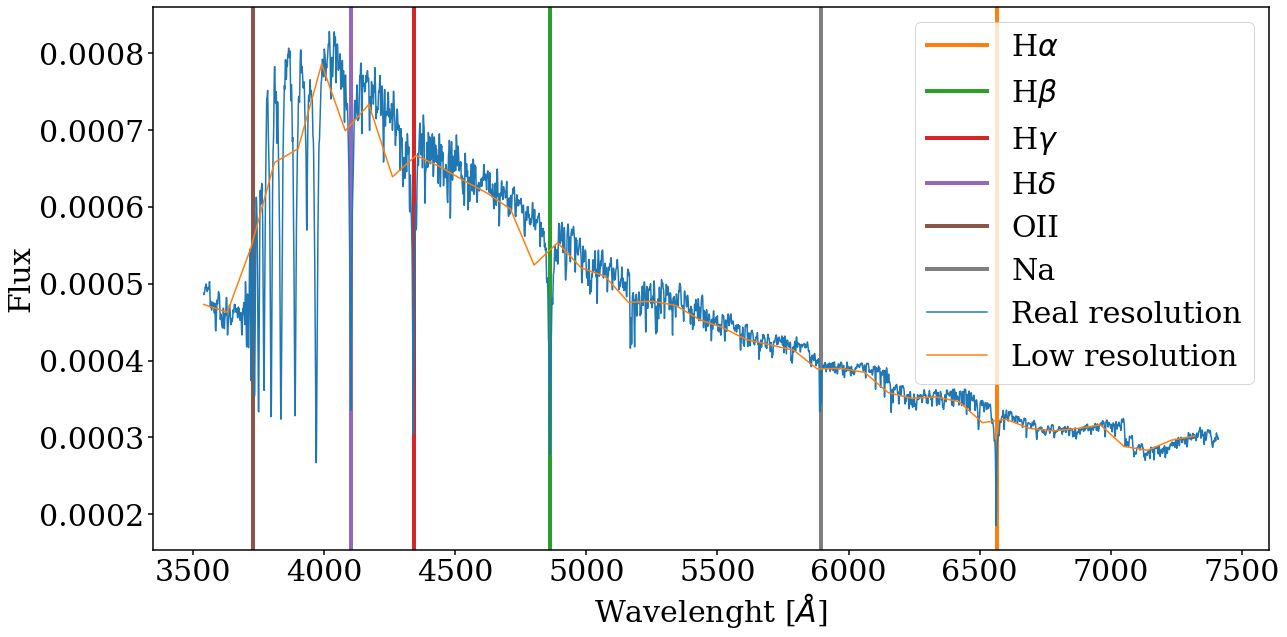

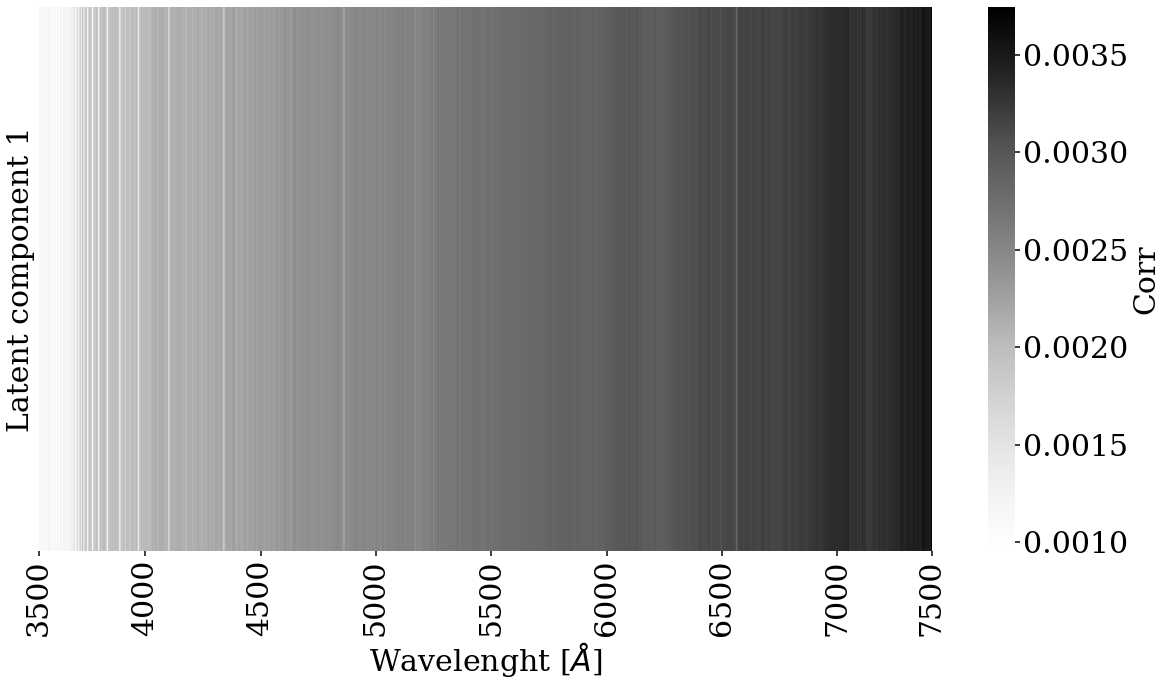

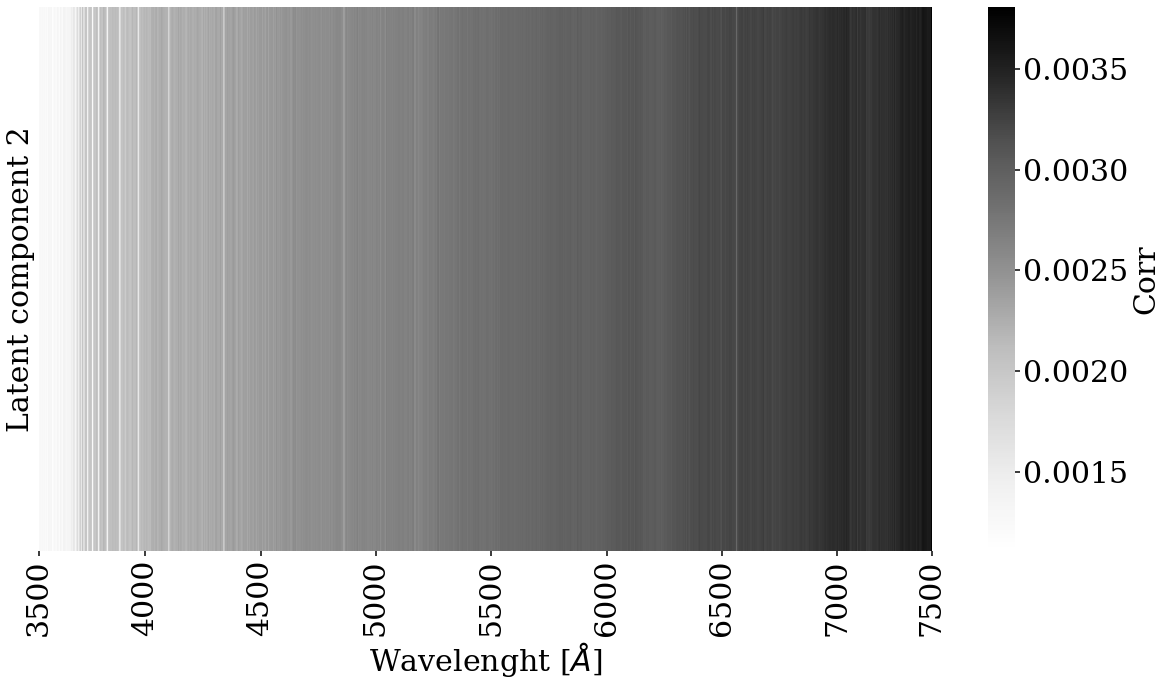

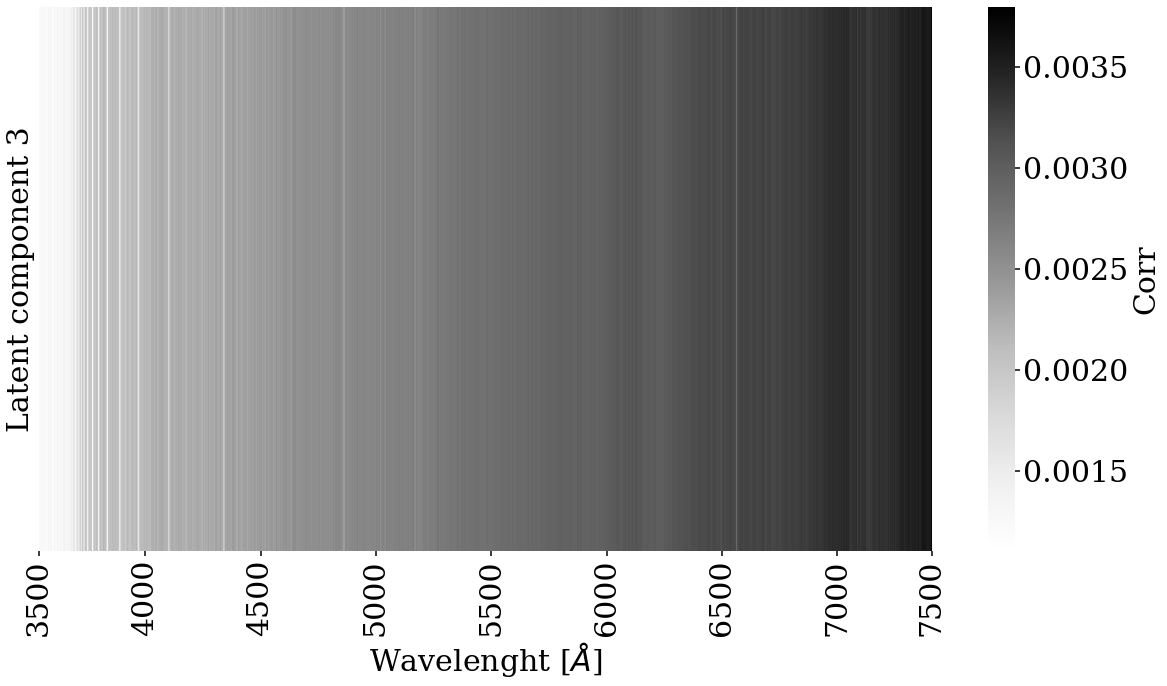

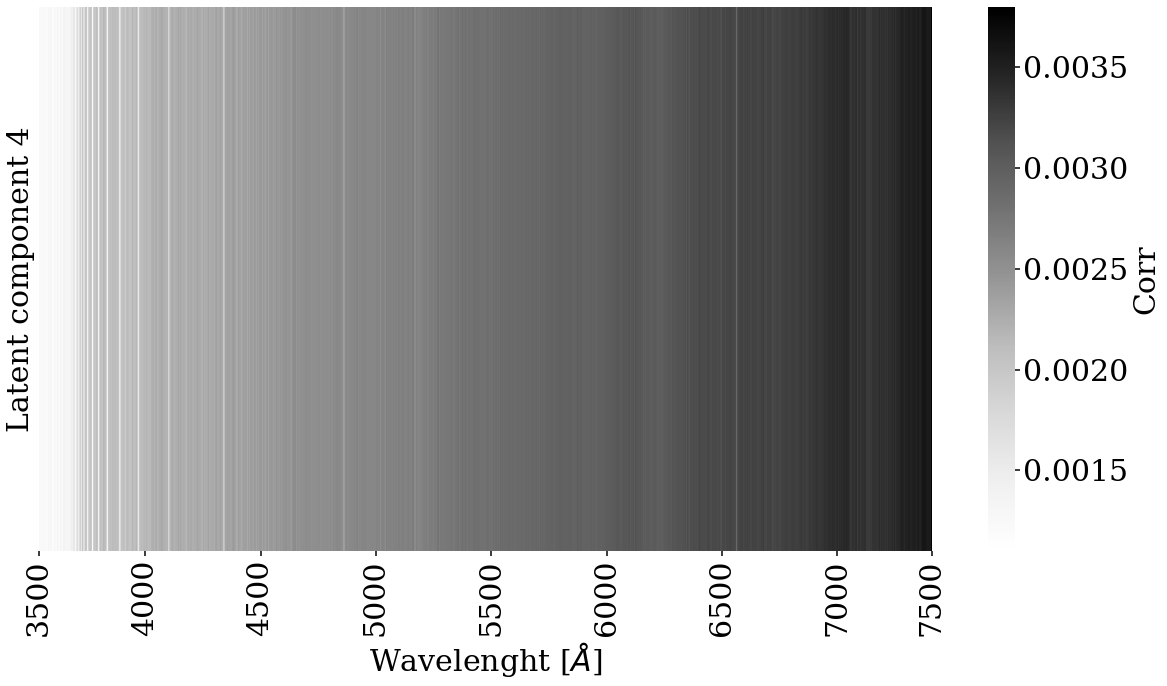

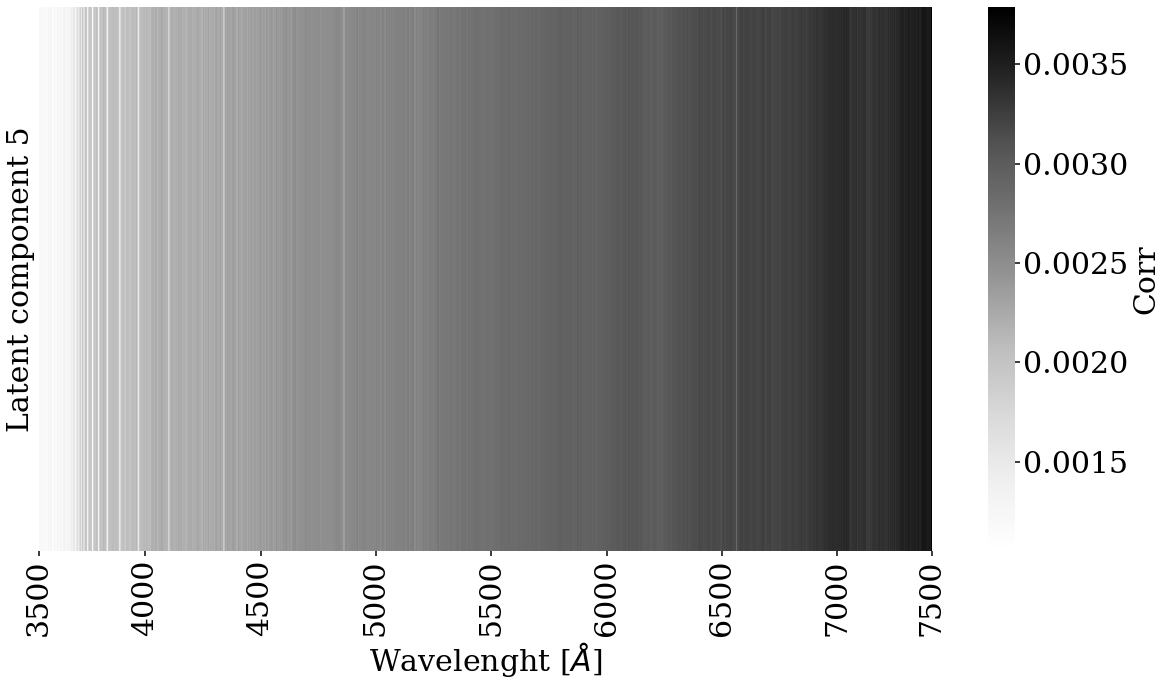

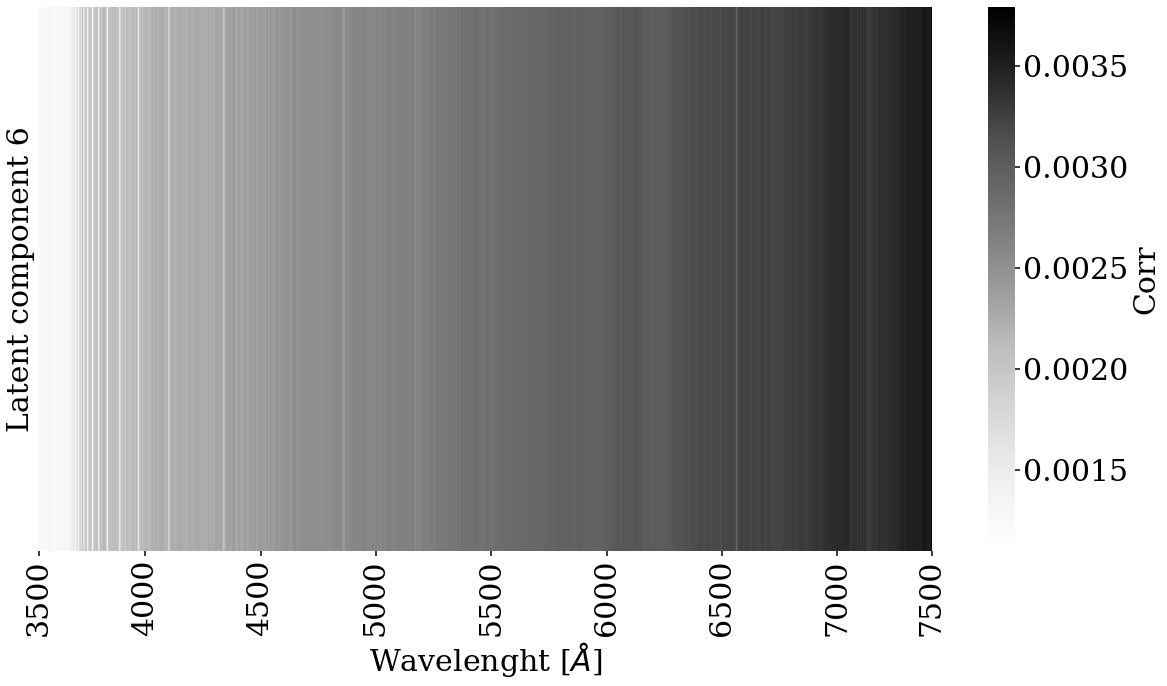

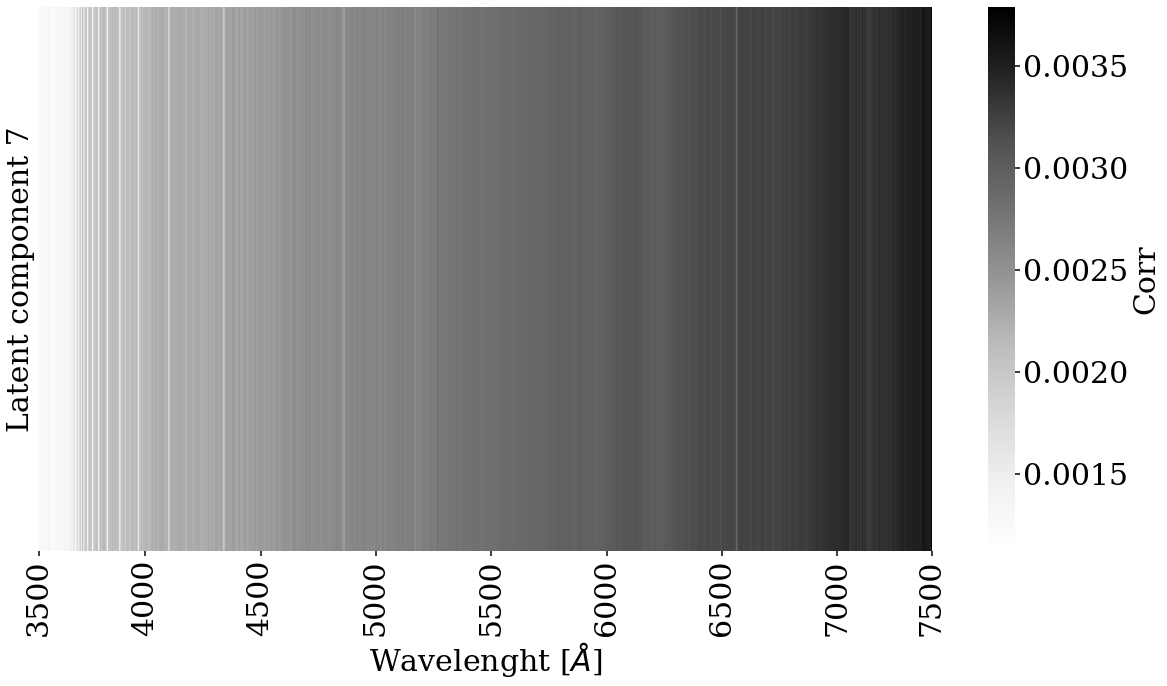

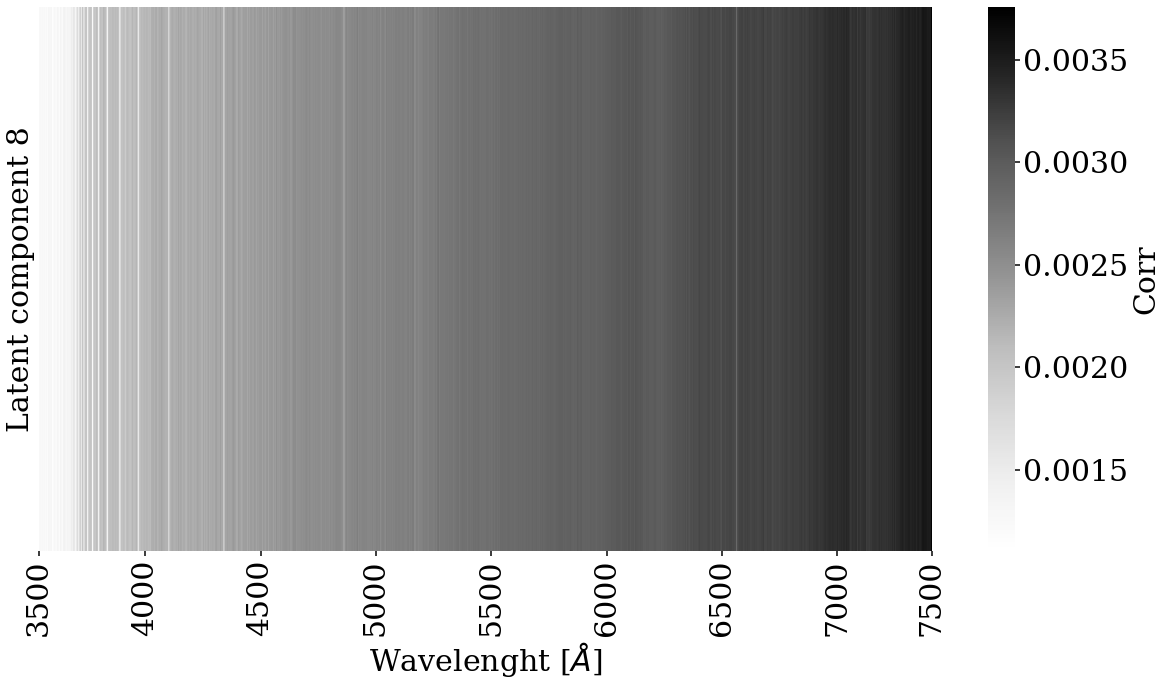

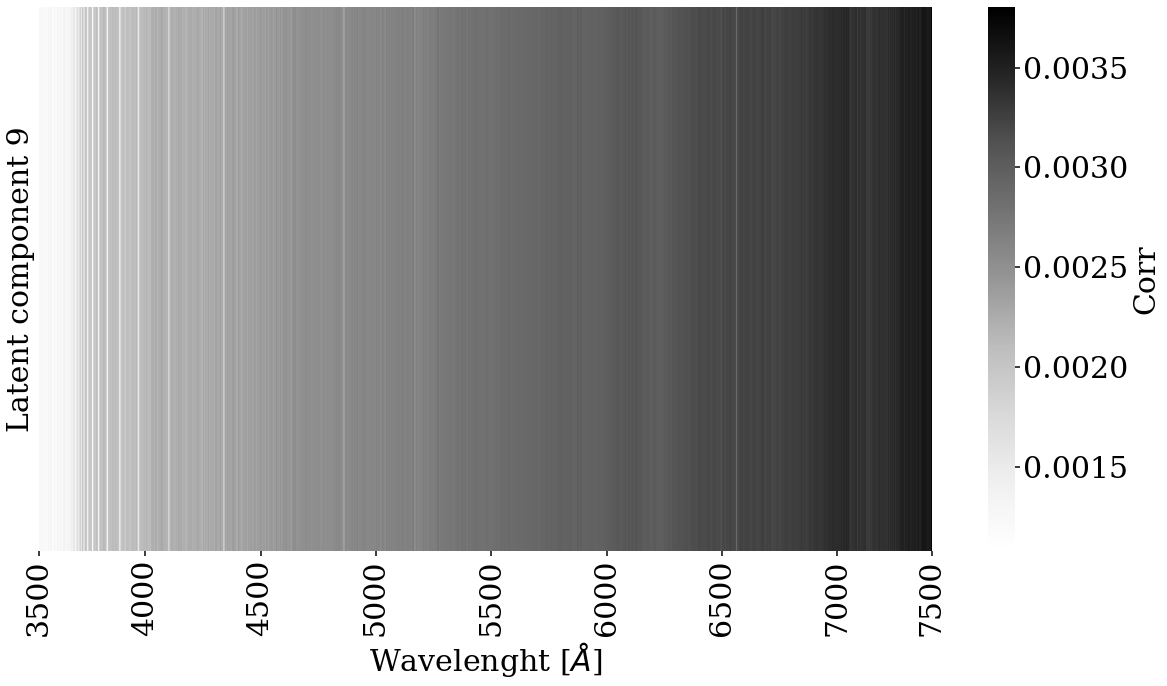

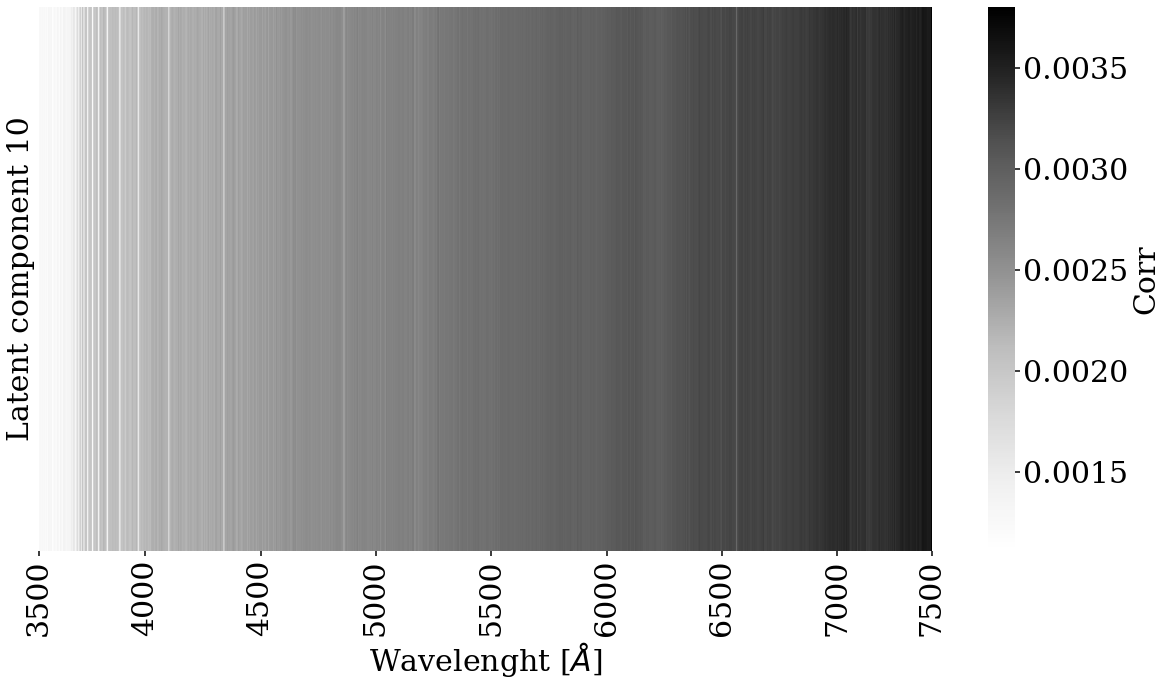

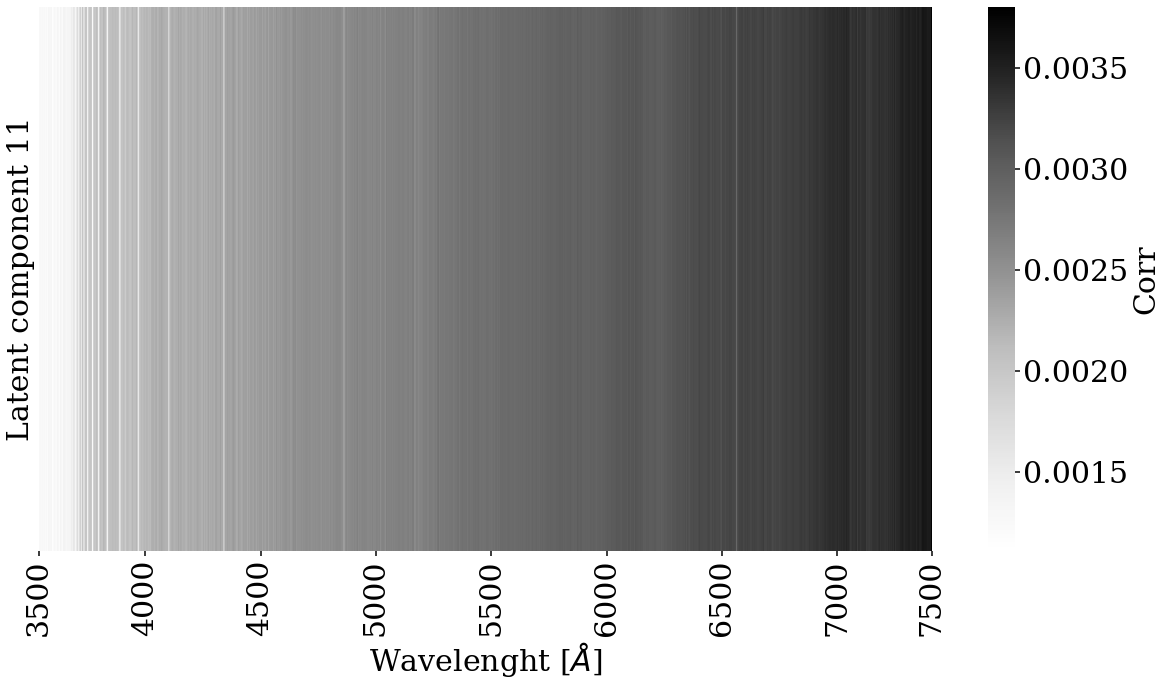

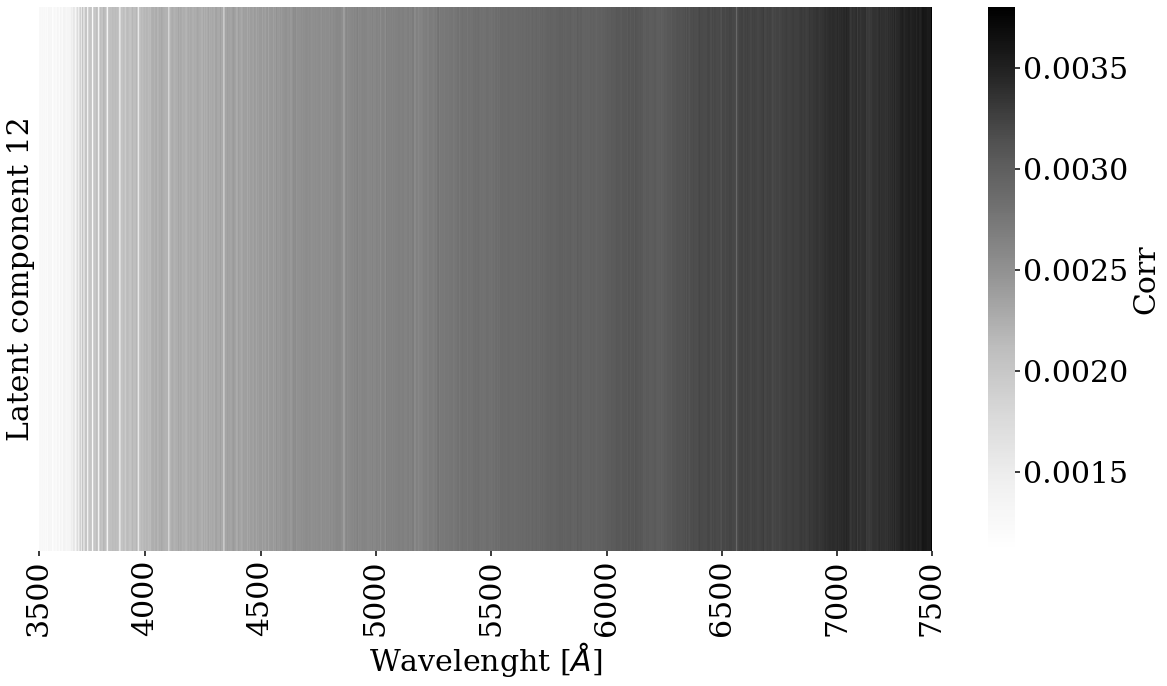

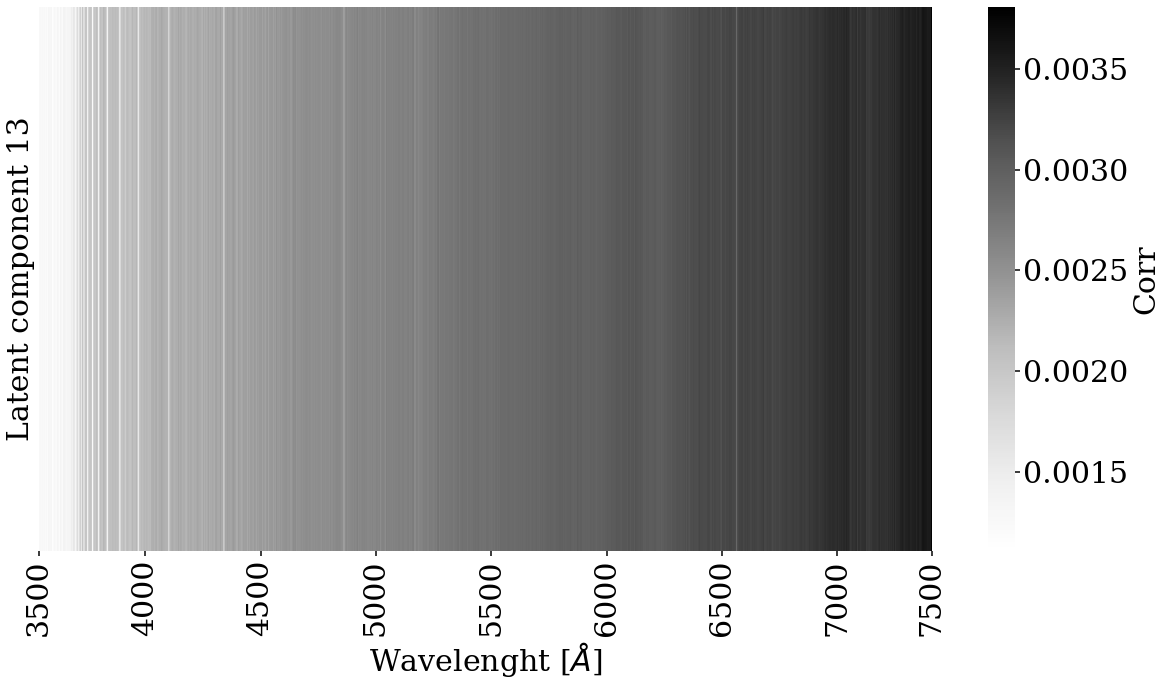

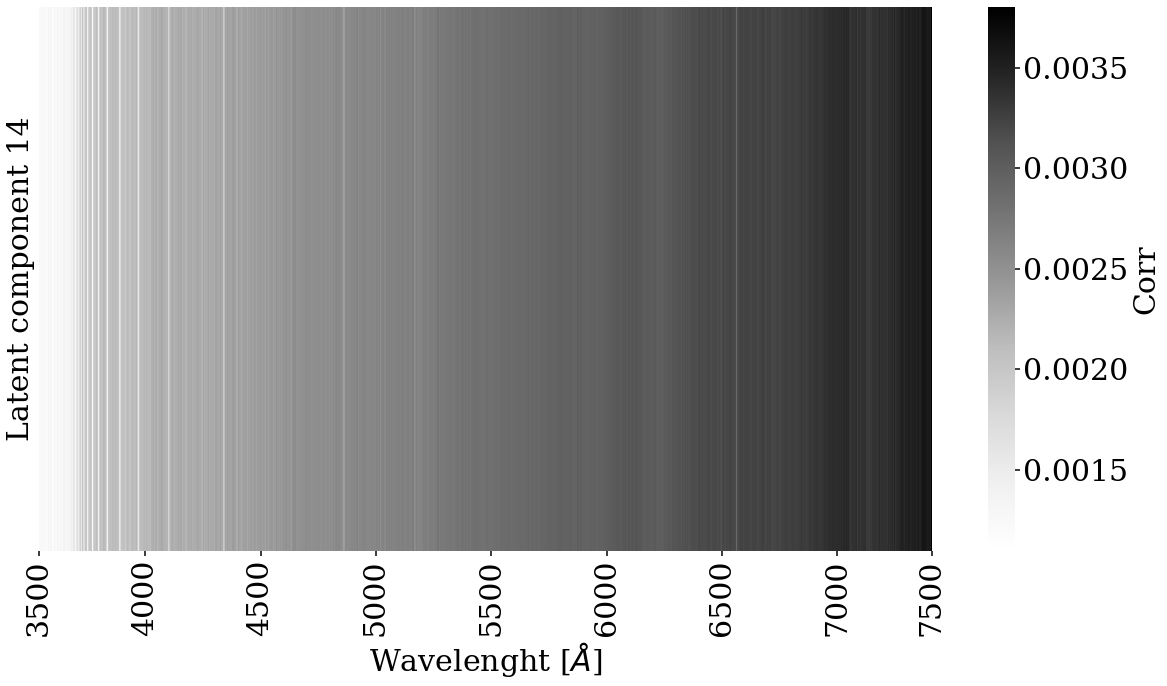

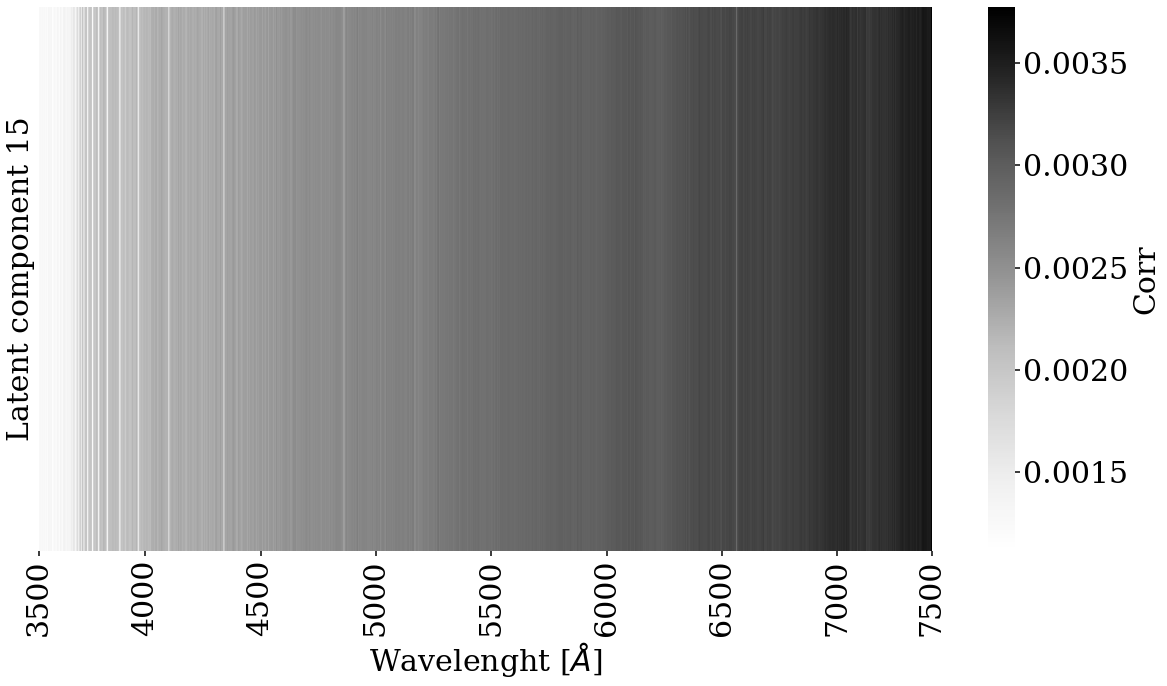

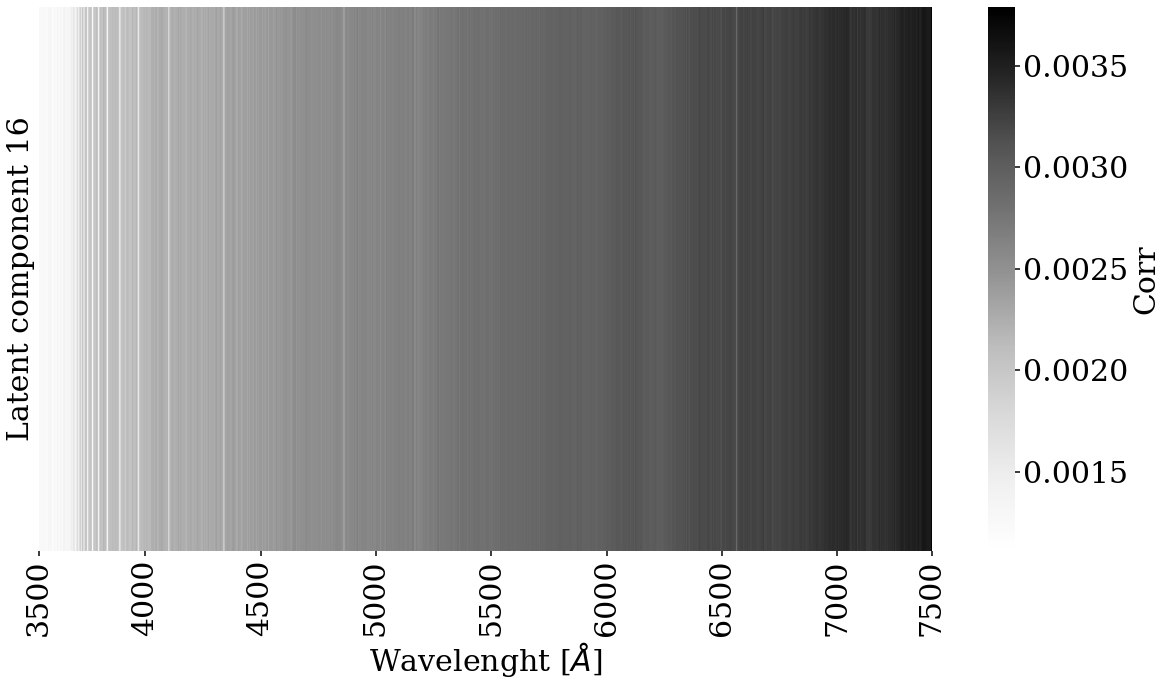

In [23]:

#the same but component by component to see better the colorbar



# correlation between latents and spectrum

import matplotlib

x_test_short=np.zeros((45000,43))


for i in range(43):
    x_test_short[:,i]=np.mean(x_test[:,i*100:(i+1)*100],axis=1)

color=['tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','gold']


plt.figure(figsize=(20,10))
#plt.xticks(np.arange(4300)[::200],labels=wave[::200],rotation=45)
plt.axvline( 6564.61,label='H$\\alpha$',lw=4,c=color[0])
plt.axvline(  4862.68,label='H$\\beta$',lw=4,c=color[1])
plt.axvline(4341.68,label='H$\\gamma$',lw=4,c=color[2])
plt.axvline(4102.89,label='H$\\delta$',lw=4,c=color[3])
plt.axvline(3727.092,label='OII',lw=4,c=color[4])
#plt.axvline(3729.875,lw=4,c=color[5]) #label='OII'
plt.axvline(5895.6,label='Na',lw=4,c=color[6])



plt.plot(wave,x_test[100,:],label='Real resolution') #real spectra
plt.plot(wave[::100],x_test_short[100,:],label='Low resolution') #low resolution spectra
plt.xlabel('Wavelenght [$\\AA$]')
plt.ylabel('Flux')
#plt.grid()

plt.legend(loc='upper right',fontsize=30)
#plt.savefig('spectra_example_non_par.png')
plt.show()





corr_map=np.corrcoef(latents_arr,x_test[:,:],rowvar=False)
corr_map_imp=corr_map[:16,16:]

xlabels=np.arange(3500,8000,500)
xticks=[]

for i in xlabels:
    xticks.append(np.argmin(np.abs(wave-i)))


for i in range(16):
    component_map=corr_map_imp[i,:]
    component_map=np.reshape(component_map,(1,4300))
    #doesnt matter the sign of the correlation
    plt.figure(figsize=(20,10))
    ax=sns.heatmap(np.abs(component_map), cmap='Greys',vmin=np.min(np.abs(component_map)), vmax=np.max(np.abs(component_map)),\
                yticklabels=[], cbar_kws={'label': 'Corr'})
    ax.set_xticks(ticks=xticks)
    ax.set_xticklabels(xlabels)
    plt.xlabel('Wavelenght [$\\AA$]')
    plt.ylabel('Latent component '+str(i+1))
    if i==15:
        plt.savefig('corr_spectra_allpos_16.png')
    plt.show()

